In [ ]:
Что происходит в коде:

✅ YOLO находит объекты: 1 person, 1 cup, 1 potted plant, 1 laptop

✅ SAM2 сегментирует каждый найденный объект

✅ Визуализация показывает маски поверх изображения

In [3]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sam2.sam2_image_predictor import SAM2ImagePredictor
import time

def show_mask(mask, ax, random_color=False):
    """Функция для отображения маски"""
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def quick_yolo_sam2(image_path):
    """Быстрый старт: YOLO + SAM2"""
    
    print("🚀 Запускаем YOLO + SAM2...")
    
    # Детекция
    print("1. Загружаем YOLO...")
    yolo = YOLO('yolo11n.pt')
    results = yolo(image_path)
    print(f"✅ YOLO нашел {sum(len(r.boxes) for r in results)} объектов")
    
    # Сегментация
    print("2. Загружаем SAM2...")
    sam = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-tiny")
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    sam.set_image(image_rgb)
    all_masks = []
    
    print("3. Сегментируем объекты...")
    for r in results:
        for box in r.boxes.xywh:
            x, y, w, h = box.cpu().numpy()
            bbox = np.array([x-w/2, y-h/2, x+w/2, y+h/2])
            
            masks, scores, _ = sam.predict(box=bbox[None, :])
            all_masks.append(masks[0])
    
    print(f"✅ Сегментировано {len(all_masks)} объектов")
    
    # Простая визуализация
    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    for mask in all_masks:
        show_mask(mask, plt.gca(), random_color=True)
    plt.axis('off')
    plt.title(f"YOLO+SAM2: {len(all_masks)} объектов")
    plt.show()

# Запуск
quick_yolo_sam2("/home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg")

🚀 Запускаем YOLO + SAM2...
1. Загружаем YOLO...

image 1/1 /home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg: 448x640 1 person, 1 cup, 1 potted plant, 1 laptop, 44.7ms
Speed: 2.6ms preprocess, 44.7ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)
✅ YOLO нашел 4 объектов
2. Загружаем SAM2...
3. Сегментируем объекты...
✅ Сегментировано 4 объектов


🚀 Запускаем YOLO + SAM2...
1. Загружаем YOLO...

image 1/1 /home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg: 448x640 1 person, 1 cup, 1 potted plant, 1 laptop, 15.0ms
Speed: 2.7ms preprocess, 15.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
✅ YOLO нашел 4 объектов
2. Загружаем SAM2...
3. Сегментируем объекты...
✅ Сегментировано 4 объектов


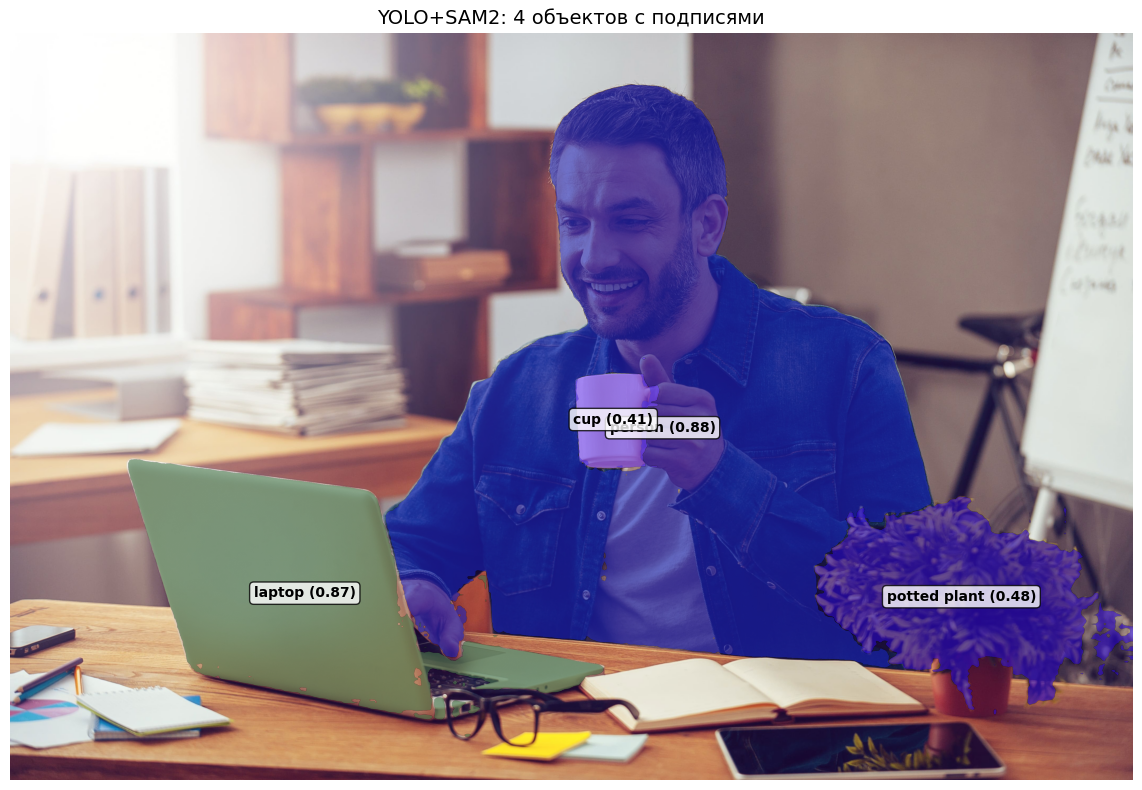


📊 ДЕТАЛЬНАЯ ИНФОРМАЦИЯ ОБ ОБЪЕКТАХ:
--------------------------------------------------
Объект 1: person
  - YOLO уверенность: 0.875
  - SAM2 качество: 0.977
  - Размер маски: 2,513,549.0 пикселей

Объект 2: laptop
  - YOLO уверенность: 0.867
  - SAM2 качество: 0.386
  - Размер маски: 829,987.0 пикселей

Объект 3: potted plant
  - YOLO уверенность: 0.478
  - SAM2 качество: 0.949
  - Размер маски: 534,839.0 пикселей

Объект 4: cup
  - YOLO уверенность: 0.409
  - SAM2 качество: 0.941
  - Размер маски: 95,280.0 пикселей



In [4]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sam2.sam2_image_predictor import SAM2ImagePredictor
import time

def show_mask(mask, ax, random_color=False):
    """Функция для отображения маски"""
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def quick_yolo_sam2(image_path):
    """Быстрый старт: YOLO + SAM2 с подписями"""
    
    print("🚀 Запускаем YOLO + SAM2...")
    
    # Детекция
    print("1. Загружаем YOLO...")
    yolo = YOLO('yolo11n.pt')
    results = yolo(image_path)
    
    # Получаем классы YOLO
    class_names = yolo.names
    print(f"✅ YOLO нашел {sum(len(r.boxes) for r in results)} объектов")
    
    # Сегментация
    print("2. Загружаем SAM2...")
    sam = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-tiny")
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    sam.set_image(image_rgb)
    all_masks = []
    object_info = []  # Будем хранить информацию об объектах
    
    print("3. Сегментируем объекты...")
    for r in results:
        for i, box in enumerate(r.boxes.xywh):
            x, y, w, h = box.cpu().numpy()
            bbox = np.array([x-w/2, y-h/2, x+w/2, y+h/2])
            
            # Получаем класс и уверенность
            cls_id = int(r.boxes.cls[i].cpu().numpy())
            conf = float(r.boxes.conf[i].cpu().numpy())
            class_name = class_names[cls_id]
            
            masks, scores, _ = sam.predict(box=bbox[None, :])
            all_masks.append(masks[0])
            
            # Сохраняем информацию об объекте
            object_info.append({
                'mask': masks[0],
                'class_name': class_name,
                'confidence': conf,
                'bbox_center': (x, y),  # Центр bbox для подписи
                'score': scores[0]  # Score от SAM2
            })
    
    print(f"✅ Сегментировано {len(all_masks)} объектов")
    
    # Визуализация с подписями
    plt.figure(figsize=(14, 8))
    plt.imshow(image_rgb)
    
    # Отображаем маски и добавляем подписи
    for i, obj in enumerate(object_info):
        show_mask(obj['mask'], plt.gca(), random_color=True)
        
        # Находим центр маски для подписи
        mask_center = find_mask_center(obj['mask'])
        
        # Создаем подпись
        label = f"{obj['class_name']} ({obj['confidence']:.2f})"
        
        # Добавляем текст с фоном для читаемости
        plt.text(mask_center[0], mask_center[1], label, 
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", 
                         facecolor='white', 
                         edgecolor='black', 
                         alpha=0.8),
                ha='center', va='center')
    
    plt.axis('off')
    plt.title(f"YOLO+SAM2: {len(all_masks)} объектов с подписями", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Выводим детальную информацию в консоль
    print("\n📊 ДЕТАЛЬНАЯ ИНФОРМАЦИЯ ОБ ОБЪЕКТАХ:")
    print("-" * 50)
    for i, obj in enumerate(object_info, 1):
        print(f"Объект {i}: {obj['class_name']}")
        print(f"  - YOLO уверенность: {obj['confidence']:.3f}")
        print(f"  - SAM2 качество: {obj['score']:.3f}")
        print(f"  - Размер маски: {np.sum(obj['mask']):,} пикселей")
        print()

def find_mask_center(mask):
    """Находит центр масс маски для размещения подписи"""
    y_coords, x_coords = np.where(mask)
    if len(x_coords) > 0 and len(y_coords) > 0:
        center_x = np.mean(x_coords)
        center_y = np.mean(y_coords)
        return (center_x, center_y)
    else:
        return (0, 0)  # fallback

# Запуск
quick_yolo_sam2("/home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg")

🚀 Запускаем YOLO + SAM2...
📐 Исходный размер изображения: 4256x2832
1. Загружаем YOLO...

image 1/1 /home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg: 448x640 1 person, 1 cup, 1 potted plant, 1 laptop, 21.5ms
Speed: 2.6ms preprocess, 21.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
✅ YOLO использовал размер: 4256x2832
⏱️ YOLO загрузка: 0.03с, инференс: 0.15с
✅ YOLO нашел 4 объектов
2. Загружаем SAM2...
⏱️ SAM2 загрузка: 0.84с, setup: 0.04с
3. Сегментируем объекты...
✅ Сегментировано 4 объектов
⏱️ Среднее время сегментации на объект: 0.035с


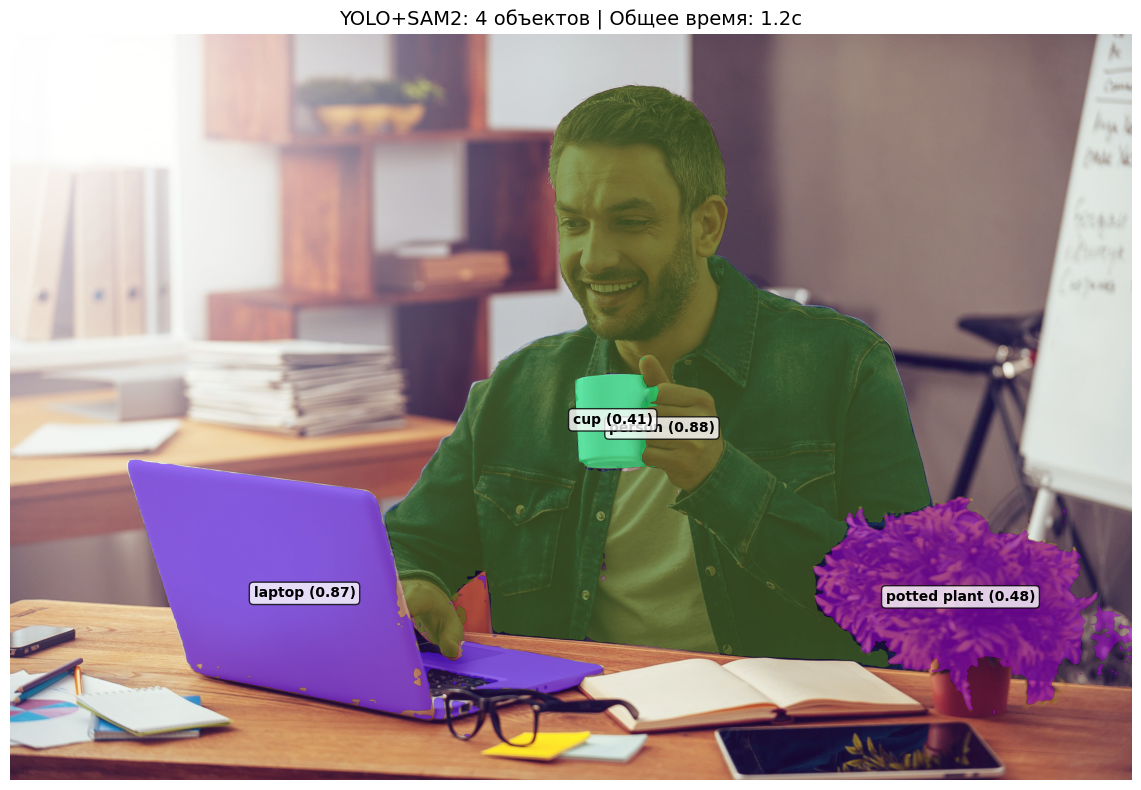


📊 СТАТИСТИКА ПРОИЗВОДИТЕЛЬНОСТИ:
--------------------------------------------------
YOLO загрузка модели: 0.03с
YOLO инференс: 0.15с
SAM2 загрузка модели: 0.84с
SAM2 setup: 0.04с
SAM2 сегментация (4 объектов): 0.14с
ОБЩЕЕ ВРЕМЯ: 1.20с
Скорость: 3.3 объектов/секунду


In [5]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sam2.sam2_image_predictor import SAM2ImagePredictor
import time

def show_mask(mask, ax, random_color=False):
    """Функция для отображения маски"""
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def quick_yolo_sam2_detailed(image_path):
    """YOLO + SAM2 с детальной информацией о ресайзах"""
    
    print("🚀 Запускаем YOLO + SAM2...")
    
    # Загружаем изображение чтобы узнать исходный размер
    image = cv2.imread(image_path)
    original_h, original_w = image.shape[:2]
    print(f"📐 Исходный размер изображения: {original_w}x{original_h}")
    
    # Детекция
    print("1. Загружаем YOLO...")
    start_time = time.time()
    yolo = YOLO('yolo11n.pt')
    yolo_load_time = time.time() - start_time
    
    start_time = time.time()
    results = yolo(image_path)
    yolo_inference_time = time.time() - start_time
    
    # Узнаем размер который использовал YOLO
    yolo_input_size = results[0].orig_shape
    print(f"✅ YOLO использовал размер: {yolo_input_size[1]}x{yolo_input_size[0]}")
    print(f"⏱️ YOLO загрузка: {yolo_load_time:.2f}с, инференс: {yolo_inference_time:.2f}с")
    
    # Получаем классы YOLO
    class_names = yolo.names
    print(f"✅ YOLO нашел {sum(len(r.boxes) for r in results)} объектов")
    
    # Сегментация
    print("2. Загружаем SAM2...")
    start_time = time.time()
    sam = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-tiny")
    sam_load_time = time.time() - start_time
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    start_time = time.time()
    sam.set_image(image_rgb)  # SAM2 работает с исходным размером!
    sam_setup_time = time.time() - start_time
    
    print(f"⏱️ SAM2 загрузка: {sam_load_time:.2f}с, setup: {sam_setup_time:.2f}с")
    
    all_masks = []
    object_info = []
    
    print("3. Сегментируем объекты...")
    segmentation_times = []
    
    for r in results:
        for i, box in enumerate(r.boxes.xywh):
            x, y, w, h = box.cpu().numpy()
            bbox = np.array([x-w/2, y-h/2, x+w/2, y+h/2])
            
            # Получаем класс и уверенность
            cls_id = int(r.boxes.cls[i].cpu().numpy())
            conf = float(r.boxes.conf[i].cpu().numpy())
            class_name = class_names[cls_id]
            
            start_time = time.time()
            masks, scores, _ = sam.predict(box=bbox[None, :])
            seg_time = time.time() - start_time
            segmentation_times.append(seg_time)
            
            all_masks.append(masks[0])
            
            object_info.append({
                'mask': masks[0],
                'class_name': class_name,
                'confidence': conf,
                'bbox_center': (x, y),
                'score': scores[0],
                'segmentation_time': seg_time
            })
    
    avg_seg_time = np.mean(segmentation_times) if segmentation_times else 0
    print(f"✅ Сегментировано {len(all_masks)} объектов")
    print(f"⏱️ Среднее время сегментации на объект: {avg_seg_time:.3f}с")
    
    # Визуализация
    plt.figure(figsize=(14, 8))
    plt.imshow(image_rgb)
    
    for i, obj in enumerate(object_info):
        show_mask(obj['mask'], plt.gca(), random_color=True)
        
        mask_center = find_mask_center(obj['mask'])
        label = f"{obj['class_name']} ({obj['confidence']:.2f})"
        
        plt.text(mask_center[0], mask_center[1], label, 
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", 
                         facecolor='white', 
                         edgecolor='black', 
                         alpha=0.8),
                ha='center', va='center')
    
    plt.axis('off')
    total_time = yolo_load_time + yolo_inference_time + sam_load_time + sam_setup_time + sum(segmentation_times)
    plt.title(f"YOLO+SAM2: {len(all_masks)} объектов | Общее время: {total_time:.1f}с", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Детальная статистика
    print("\n📊 СТАТИСТИКА ПРОИЗВОДИТЕЛЬНОСТИ:")
    print("-" * 50)
    print(f"YOLO загрузка модели: {yolo_load_time:.2f}с")
    print(f"YOLO инференс: {yolo_inference_time:.2f}с")
    print(f"SAM2 загрузка модели: {sam_load_time:.2f}с")
    print(f"SAM2 setup: {sam_setup_time:.2f}с")
    print(f"SAM2 сегментация ({len(segmentation_times)} объектов): {sum(segmentation_times):.2f}с")
    print(f"ОБЩЕЕ ВРЕМЯ: {total_time:.2f}с")
    print(f"Скорость: {len(all_masks)/total_time:.1f} объектов/секунду")

def find_mask_center(mask):
    """Находит центр масс маски для размещения подписи"""
    y_coords, x_coords = np.where(mask)
    if len(x_coords) > 0 and len(y_coords) > 0:
        center_x = np.mean(x_coords)
        center_y = np.mean(y_coords)
        return (center_x, center_y)
    else:
        return (0, 0)

# Запуск
quick_yolo_sam2_detailed("/home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg")

In [ ]:
# pip install ultralytics
import torch
import cv2
import numpy as np
from ultralytics import YOLO
from sam2.sam2_image_predictor import SAM2ImagePredictor

def yolo_sam2_pipeline(image_path):
    """YOLO детекция -> SAM2 сегментация"""
    
    # 1. Детекция объектов YOLO
    yolo_model = YOLO('yolo11n.pt')  # Автоскачается
    results = yolo_model(image_path)
    
    # 2. Загрузка SAM2
    sam_predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-tiny")
    
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
        sam_predictor.set_image(image_rgb)
        
        # 3. Сегментация каждого обнаруженного объекта
        all_masks = []
        for r in results:
            boxes = r.boxes.xywh  # YOLO bbox в формате [x_center, y_center, width, height]
            
            for box in boxes:
                x_center, y_center, width, height = box.cpu().numpy()
                
                # Конвертируем в формат SAM2 [x_min, y_min, x_max, y_max]
                bbox = np.array([
                    x_center - width/2,   # x_min
                    y_center - height/2,  # y_min  
                    x_center + width/2,   # x_max
                    y_center + height/2   # y_max
                ])
                
                # Сегментируем объект по bbox
                masks, scores, _ = sam_predictor.predict(box=bbox[None, :])
                all_masks.append(masks[0])  # Берем лучшую маску
    
    # Визуализация
    visualize_detection_segmentation(image_rgb, results, all_masks)

def visualize_detection_segmentation(image, yolo_results, sam_masks):
    """Визуализация детекции и сегментации"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Исходное изображение
    ax1.imshow(image)
    ax1.set_title("Исходное изображение")
    ax1.axis('off')
    
    # 2. YOLO детекция
    ax2.imshow(image)
    for r in yolo_results:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())
            
            # Рисуем bbox
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                               linewidth=2, edgecolor='red', facecolor='none')
            ax2.add_patch(rect)
            ax2.text(x1, y1-10, f'Class {cls}: {conf:.2f}', 
                    bbox=dict(boxstyle="round", facecolor='red', alpha=0.8))
    ax2.set_title("YOLO Детекция")
    ax2.axis('off')
    
    # 3. SAM2 Сегментация
    ax3.imshow(image)
    for mask in sam_masks:
        show_mask(mask, ax3, random_color=True)
    ax3.set_title("SAM2 Сегментация")
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sam2.sam2_image_predictor import SAM2ImagePredictor
import time

def quick_yolo_sam2(image_path):
    """Быстрый старт: YOLO + SAM2 с отладкой"""
    
    print("🚀 Запускаем YOLO + SAM2 пайплайн...")
    
    # 1. Загрузка YOLO
    print("1. Загружаем YOLO модель...")
    start_time = time.time()
    yolo = YOLO('yolo11n.pt')  # Автоскачается при первом запуске
    yolo_time = time.time() - start_time
    print(f"   ✅ YOLO загружен за {yolo_time:.1f} сек")
    
    # 2. Детекция YOLO
    print("2. Запускаем детекцию YOLO...")
    start_time = time.time()
    results = yolo(image_path)
    detection_time = time.time() - start_time
    print(f"   ✅ YOLO детекция завершена за {detection_time:.1f} сек")
    
    # Проверяем найденные объекты
    for i, r in enumerate(results):
        print(f"   📊 Найдено объектов: {len(r.boxes)}")
        if len(r.boxes) > 0:
            for j, box in enumerate(r.boxes):
                cls = int(box.cls[0])
                conf = float(box.conf[0])
                print(f"      Объект {j+1}: класс={cls}, уверенность={conf:.3f}")
    
    # 3. Загрузка SAM2
    print("3. Загружаем SAM2 модель...")
    start_time = time.time()
    sam = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-tiny")
    sam_time = time.time() - start_time
    print(f"   ✅ SAM2 загружен за {sam_time:.1f} сек")
    
    # 4. Загрузка изображения
    print("4. Загружаем изображение...")
    image = cv2.imread(image_path)
    if image is None:
        print(f"   ❌ Ошибка: не могу загрузить изображение {image_path}")
        return
        
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(f"   📐 Размер изображения: {image_rgb.shape[1]}x{image_rgb.shape[0]}")
    
    # 5. Установка изображения в SAM2
    print("5. Устанавливаем изображение в SAM2...")
    sam.set_image(image_rgb)
    
    # 6. Сегментация найденных объектов
    print("6. Запускаем сегментацию объектов...")
    all_masks = []
    
    for i, r in enumerate(results):
        if len(r.boxes) == 0:
            print("   ⚠️ Нет объектов для сегментации")
            continue
            
        for j, box in enumerate(r.boxes.xywh):
            x, y, w, h = box.cpu().numpy()
            bbox = np.array([x-w/2, y-h/2, x+w/2, y+h/2])
            
            print(f"   🎯 Сегментируем объект {j+1}...")
            start_time = time.time()
            
            masks, scores, _ = sam.predict(box=bbox[None, :])
            
            seg_time = time.time() - start_time
            print(f"      ✅ Сегментация за {seg_time:.2f} сек, score: {scores[0]:.3f}")
            
            all_masks.append(masks[0])
    
    print(f"7. 📊 Всего сегментировано объектов: {len(all_masks)}")
    
    # 7. Визуализация
    print("8. Создаем визуализацию...")
    plt.figure(figsize=(15, 5))
    
    # Исходное изображение
    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title("Исходное изображение")
    plt.axis('off')
    
    # Детекция YOLO
    plt.subplot(1, 3, 2)
    plt.imshow(image_rgb)
    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())
            
            # Рисуем bbox
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                               linewidth=2, edgecolor='red', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x1, y1-5, f'Class {cls}: {conf:.2f}', 
                    bbox=dict(boxstyle="round", facecolor='red', alpha=0.8))
    plt.title("YOLO Детекция")
    plt.axis('off')
    
    # Сегментация SAM2
    plt.subplot(1, 3, 3)
    plt.imshow(image_rgb)
    for mask in all_masks:
        show_mask(mask, plt.gca(), random_color=True)
    plt.title("SAM2 Сегментация")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("🎉 Готово!")

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# Запуск с подробным выводом
print("=" * 50)
quick_yolo_sam2("/home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg")
print("=" * 50)